In [52]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm
from datetime import datetime
plt.rcParams['text.usetex'] = True

# Load data

In [53]:
commits = pd.read_csv('../data/commits.csv.gz')
files = pd.read_csv('../data/touched_files.csv.gz')
lines = pd.read_csv('../data/touched_lines.csv.gz')
commits['date'] = commits['date'].apply(datetime.fromtimestamp)
for x in [commits, files, lines]:
    x['v1'] = x['v1..v2'].apply(lambda d: d.split('..')[0].replace('v',''))
    x['v2'] = x['v1..v2'].apply(lambda d: d.split('..')[1].replace('v',''))
    x.drop('v1..v2', axis=1, inplace=True)
    x.fillna('undefined',inplace=True)
    x['repo'] = x['owner']+'/'+x['repo']
commits.drop(['author','email'], axis=1, inplace=True)

In [54]:
print(commits.repo.unique().size, lines.repo.unique().size, files.repo.unique().size)
print(commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11156 11156 11156
11156 11156 11156


In [55]:
print(commits.repo.unique().size, lines.repo.unique().size, files.repo.unique().size)

11156 11156 11156


In [56]:
print(commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11156 11156 11156


# Remove repos that refer to multiples projects

In [57]:
df_tmp = (commits[['id','role','repo']].drop_duplicates().groupby('repo').count()[['role']].reset_index())
df_tmp = df_tmp.query('role >1')

commits = commits[~commits.repo.isin(df_tmp.repo)]
lines = lines[~lines.repo.isin(df_tmp.repo)]
files = files[~files.repo.isin(df_tmp.repo)]

releases = (commits[['id','v1','v2','date']]
            .sort_values('date')
            .groupby(['id','v1','v2'])
            .first()
            .reset_index()
           )

In [58]:
releases.sample()

,id,v1,v2,date
89855,vivekyaji.ansible_supervisord_program,1.1.1,1.1.2,2018-03-28 04:56:23


In [59]:
print(releases.id.unique().size, commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11156 11156 11156 11156


In [60]:
print(releases.id.unique().size, commits.repo.unique().size, lines.repo.unique().size, files.repo.unique().size)

11156 11156 11156 11156


In [61]:
len(releases)

92716

# Remove those that do not have any releases

In [62]:
releases = releases.query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904" or v2 != "HEAD"')
commits = commits.query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904" or v2 != "HEAD"')
files = files.query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904" or v2 != "HEAD"')
lines = lines.query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904" or v2 != "HEAD"')

In [63]:
print(releases.id.unique().size, commits.id.unique().size, lines.id.unique().size, files.id.unique().size, releases.id.unique().size)

11156 11156 11156 11156 11156


# RQ0: SEMVER syntaxe compliance

In [64]:
RE_SEMVER = r'^(?:v|V)?(?P<v_major>\d+)\.(?P<v_minor>\d+)\.(?P<v_patch>\d+)(?P<v_misc>.*)$'
def comply_semver(series_of_releases):
    extracted = series_of_releases.str.extract(RE_SEMVER, expand=True)
    return (
        extracted
        [['v_major', 'v_minor', 'v_patch']]
        .astype('str')
        .assign(Semver=lambda d: d['v_major'] + '.' + d['v_minor'] + '.' + d['v_patch'])
        ['Semver']
    )

In [65]:
#releases_comply = pd.concat([releases[['id','to']], releases[['id','from']].rename(columns={'from':'to'})])
#releases_comply.drop_duplicates(inplace=True)

In [66]:
for x in [releases, commits, files, lines]:
    x['fromm'] = comply_semver(x['v1'])
    x['tot'] = comply_semver(x['v2'])
    
#for x in [releases_comply]:
#    x['to'] = comply_semver(x['to'])

In [67]:
releases = releases.query('v2 != "HEAD"')
commits = commits.query('v2 != "HEAD"')
files = files.query('v2 != "HEAD"')
lines = lines.query('v2 != "HEAD"')

In [68]:
releases.id.unique().size

11156

In [69]:
def type_release(v0,v1,v2):
    if v0 == "4b825dc642cb6eb9a060e54bf8d69288fbee4904":
        return 'initial'
    v1=v1.split('.')
    v2=v2.split('.')
    
    if v1[-1] == 'nan' or v2[-1] == "nan":
        return 'notSemver'
    if v1[0]!=v2[0]:
        return 'major'
    if v1[1]!=v2[1]:
        return 'minor'
    if v1[2]!=v2[2]:
        return 'patch'
    return 'pre'

for x in [ releases, commits, files, lines]:
    x['release'] = x.apply(lambda d: type_release(d['v1'], d['fromm'], d['tot']), axis=1)

In [70]:
len(releases)

92716

In [71]:
releases.query('release == "pre"').id.unique().size

225

In [72]:
commits = commits.query('release != "notSemver" and release != "pre"')
lines = lines.query('release != "notSemver" and release != "pre"')
files = files.query('release != "notSemver" and release != "pre"')
releases = releases.query('release != "notSemver" and release != "pre"')

In [ ]:
releases.fromm = releases.fromm.replace({'nan.nan.nan':'first commit'})
lines.fromm = lines.fromm.replace({'nan.nan.nan':'first commit'})
commits.fromm = commits.fromm.replace({'nan.nan.nan':'first commit'})
files.fromm = files.fromm.replace({'nan.nan.nan':'first commit'})

In [74]:
# Don't remove duplicates
releases.groupby('release').count()*100/len(releases)

,id,v1,v2,date,fromm,tot
release,,,,,,
initial,12.112263,12.112263,12.112263,12.112263,12.112263,12.112263
major,4.313555,4.313555,4.313555,4.313555,4.313555,4.313555
minor,20.097715,20.097715,20.097715,20.097715,20.097715,20.097715
patch,63.476467,63.476467,63.476467,63.476467,63.476467,63.476467


In [75]:
print(len(releases),len(commits), len(lines), len(files))

92105 594188 93129 761982


In [76]:
print(releases.id.unique().size,commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11156 11156 11156 11156


In [77]:
len(df_tmp_all)

8587

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


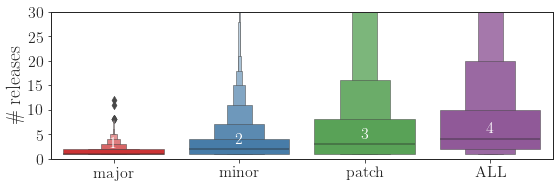

In [84]:
# Number of releases per project
df_tmp_all = (releases
              .query('release != "initial"')
              .groupby(['id'])
              .count()[['fromm']]
              .reset_index()
             )
df_tmp_all['release'] =  'ALL'

df_tmp = (releases
          .groupby(['id','release'])
          .count()[['fromm']]
          .reset_index()
          .query('release != "initial"')
         )
df_tmp = pd.concat([df_tmp,df_tmp_all])
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="fromm",
                 data=df_tmp, 
                 order = ['major','minor','patch','ALL'],
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='\# releases',
    ylim=(0,30)
)
plt.yticks(pd.np.arange(0, 31, 5)) 

position =0
for release in ['major','minor','patch','ALL']:
    value = df_tmp.query('release == "{}"'.format(release)).fromm.median()
    ax.annotate('{}'.format(int(value)), (position, value+2), ha='center', va='center', color='white')
    position = position+1

In [85]:
df_tmp.query('fromm>100 and release =="ALL"').id.unique()

array(['alvistack.bamboo', 'alvistack.bitbucket', 'alvistack.confluence',
       'alvistack.crowd', 'alvistack.docker', 'alvistack.fisheye',
       'alvistack.git', 'alvistack.jira', 'alvistack.openjdk',
       'alvistack.python', 'brianshumate.consul',
       'cloudalchemy.prometheus', 'dockpack.ansible_consul',
       'gantsign.intellij', 'gofrolist.ansible_consul',
       'jetune.bitbucket', 'jetune.jira', 'matrixcrawler.ansible_consul',
       'nycrecords.ansible_consul', 'robertdebock.bootstrap',
       'sampathinturi.ansible_prometheus', 't0k4rt.ansible-consul',
       'ykhemani.ansible-consul'], dtype=object)

In [97]:
(commits
 [commits.id.isin(df_tmp.query('fromm>100 and release =="ALL"').id)]
 .groupby(['id','tot'])
 .count()[['commit']]
 .reset_index()
 .commit
 .median()
)

3.0

In [34]:
df_tmp.query('release =="major"').sort_values('fromm').tail()

,id,release,fromm
19786,purplenetwork.apache,major,8
8735,dev-sec.ssh-hardening,major,8
2094,OndrejHome.pcs-modules-2,major,8
11422,githubixx.kubectl,major,11
2085,OndrejHome.ha-cluster-pacemaker,major,12


In [36]:
for r in ['major','minor','patch','ALL']:
    print(r, df_tmp.query('release =="{}"'.format(r))['fromm'].median())

major 1.0
minor 2.0
patch 3.0
ALL 4.0


In [36]:
for r1 in ['major','minor','patch']:
    for r2 in ['major','minor','patch']:
        if r1<=r2:
            continue
        print((r1,r2),scipy.stats.mannwhitneyu(df_tmp.query('release =="{}"'.format(r1))['fromm'],
                                       df_tmp.query('release =="{}"'.format(r2))['fromm']))
        print(effect_size.cliffsDelta(df_tmp.query('release =="{}"'.format(r1))['fromm'],
                                       df_tmp.query('release =="{}"'.format(r2))['fromm']))

                               

('minor', 'major') MannwhitneyuResult(statistic=4031959.5, pvalue=2.864313014252559e-185)
d=0.3811071386140529
True
('patch', 'major') MannwhitneyuResult(statistic=4216019.5, pvalue=0.0)
d=0.5611720793904317
True
('patch', 'minor') MannwhitneyuResult(statistic=14594796.5, pvalue=5.909447963862502e-108)
d=0.22753984550052225
True


In [30]:
releases['month'] = releases['date'].apply(lambda d: str(d).split('-')[0]+'-'+str(d).split('-')[1])
releases['year'] = releases['date'].apply(lambda d: str(d).split('-')[0])

tmp_releases = (releases
               .groupby(['id','release','year'])
               .count()[['fromm']]
               .reset_index()
               .query('release != "initial"'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


([<matplotlib.axis.YTick at 0x7f5d2477bf98>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

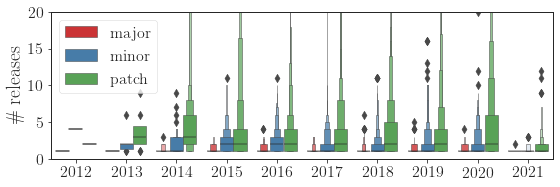

In [31]:
# Number of releases per project
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="year", 
                 y="fromm",
                 hue = 'release',
                 data=tmp_releases.sort_values('year'), 
                 hue_order = ['major','minor','patch'],
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='\# releases',
    ylim=(0,20)
)
ax.legend(loc='upper left')
plt.yticks(pd.np.arange(0, 21, 5)) 

# RQ2: How much effort does it take to create role versions?


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


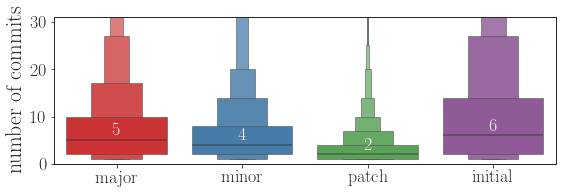

In [196]:
# Number of commits between two successive releases
df_tmp = (commits[['repo','v1','v2','release','commit']]
          .drop_duplicates()
          .groupby(['repo','release','v1','v2'])
          .count()[['commit']]
          .reset_index()
         )

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="commit",
                 data=df_tmp, 
                 order = ['major','minor','patch','initial'],
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='number of commits',
    ylim=(0,31)
)

position =0
for release in ['major','minor','patch','initial']:
    value = df_tmp.query('release == "{}"'.format(release)).commit.median()
    ax.annotate('{}'.format(int(value)), (position, value+2), ha='center', va='center', color='white')
    position = position+1
    
plt.yticks(pd.np.arange(0, 31, 10)) 

In [191]:
for r in ['major','minor','patch','initial']:
    print(r, 'mean', df_tmp.query('release =="{}"'.format(r))['commit'].mean())
    print(r, 'median', df_tmp.query('release =="{}"'.format(r))['commit'].median())

major mean 11.610873395419079
major median 5.0
minor mean 8.455026740856788
minor median 4.0
patch mean 3.6926024116993075
patch median 2.0
initial mean 15.745697382574399
initial median 6.0


In [39]:
for r1 in ['major','minor','patch']:
    for r2 in ['major','minor','patch']:
        if r1<=r2:
            continue
        print((r1,r2),scipy.stats.mannwhitneyu(df_tmp.query('release =="{}"'.format(r1))['commit'],
                                       df_tmp.query('release =="{}"'.format(r2))['commit']))
        print(effect_size.cliffsDelta(df_tmp.query('release =="{}"'.format(r1))['commit'],
                                       df_tmp.query('release =="{}"'.format(r2))['commit']))

                               

('minor', 'major') MannwhitneyuResult(statistic=34376251.5, pvalue=4.2883352365912845e-11)
d=-0.06515401356650775
False
('patch', 'major') MannwhitneyuResult(statistic=69895588.0, pvalue=0.0)
d=-0.39818190815887167
True
('patch', 'minor') MannwhitneyuResult(statistic=351776448.5, pvalue=0.0)
d=-0.3499138391057376
True


In [ ]:
releases_commits = releases[['id','v1','v2','date','release']]
releases_commits['previous'] = releases_commits.sort_values(['id','date']).groupby('id').release.shift(1)

In [41]:
print(releases.id.unique().size,commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11156 11156 11156 11156


### Let's prepare releases dataframe: it will contain the type of the previous release

In [ ]:
releases_commits = releases[['id','v1','v2','date','release']]

releases_commits['previous'] = releases_commits.sort_values(['id','date']).groupby('id').release.shift(1)

releases_commits.fillna('void', inplace=True)
releases_commits.drop(['release','date'], axis=1, inplace=True)

commits = (commits
           .merge(releases_commits,
                  on = ['id','v1','v2']
                 )
          )

lines = (lines
           .merge(releases_commits,
                  on = ['id','v1','v2']
                 )
          )

files = (files
           .merge(releases_commits,
                  on = ['id','v1','v2']
                 )
          )
print(releases.id.unique().size,commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

#### Since we found that there are more patch and minor releases than major releases. We expect to find that it takes more commits to create a major release from an other (not successive) major release.

#### For this reason, we only need to analyze the successive releases

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


([<matplotlib.axis.YTick at 0x7efdef394fd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

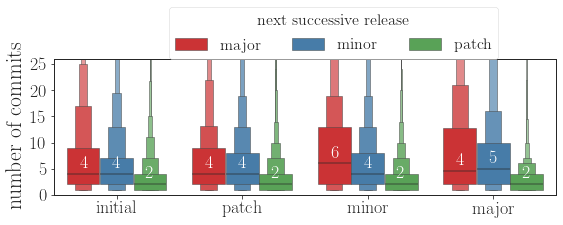

In [197]:
# Number of commits between two successive releases
df_tmp = (commits[['repo','v1','v2','release','commit','previous']]
          .drop_duplicates()
          .groupby(['repo','release','previous','v1','v2'])
          .count()[['commit']]
          .reset_index()
         )
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.5)
ax = sns.boxenplot(x="previous", 
                 y="commit",
                 hue='release',
                 order = ['initial','patch','minor','major'],
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='number of commits',
    ylim=(0,26)
)

for previous in ['initial','patch','minor','major']:
    if previous == 'initial':
        position =-0.26
    for release in ['major','minor','patch']:
        value = df_tmp.query('previous == "{}" and release == "{}"'.format(previous,release)).commit.median()
        ax.annotate('{}'.format(int(value)), (position, value+2), ha='center', va='center', color='white')
        position = position+0.26
    position = position+0.22
    
ax.legend( title ='next successive release', fontsize=16, title_fontsize=16, ncol=4, bbox_to_anchor= (0.9, 1.44))
plt.yticks(pd.np.arange(0, 26, 5)) 

In [198]:
df_tmp.query('previous == "patch" and release == "patch"').commit.median()

2.0

In [199]:
lines ['changes'] = lines['deletions'] + lines['insertions']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


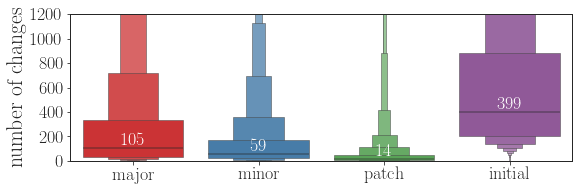

In [207]:
# Number of changes between two successive releases
# You can try with ['insertions','deletions','changes']

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="changes",
                 data=lines, 
                 order = ['major','minor','patch','initial'],
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='number of changes',
    ylim=(0,1201)
)

position =0
for release in ['major','minor','patch','initial']:
    value = lines.query('release == "{}"'.format(release)).changes.median()
    ax.annotate('{}'.format(int(value)), (position, value+60), ha='center', va='center', color='white')
    position = position+1
    
plt.yticks(pd.np.arange(0, 1201, 200)) 

In [208]:
for r in ['major','minor','patch','initial']:
    print(r, 'mean', lines.query('release =="{}"'.format(r))['changes'].mean())
    print(r, 'median', lines.query('release =="{}"'.format(r))['changes'].median())

major mean 557.6232066448528
major median 105.0
minor mean 572.7453946302198
minor median 59.0
patch mean 138.5428033866416
patch median 14.0
initial mean 1029.7282179992828
initial median 399.0


In [209]:
for r1 in ['major','minor','patch']:
    for r2 in ['major','minor','patch']:
        if r1<=r2:
            continue
        print((r1,r2),scipy.stats.mannwhitneyu(lines.query('release =="{}"'.format(r1))['changes'],
                                       lines.query('release =="{}"'.format(r2))['changes']))
        print(effect_size.cliffsDelta(lines.query('release =="{}"'.format(r1))['changes'],
                                       lines.query('release =="{}"'.format(r2))['changes']))

                               

('minor', 'major') MannwhitneyuResult(statistic=29522722.0, pvalue=3.0995827197752066e-85)
d=-0.1971434648628934
True
('patch', 'major') MannwhitneyuResult(statistic=49132600.5, pvalue=0.0)
d=-0.5769563040216148
True
('patch', 'minor') MannwhitneyuResult(statistic=301048938.0, pvalue=0.0)
d=-0.44365875208466427
True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


([<matplotlib.axis.YTick at 0x7efe5fb500b8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

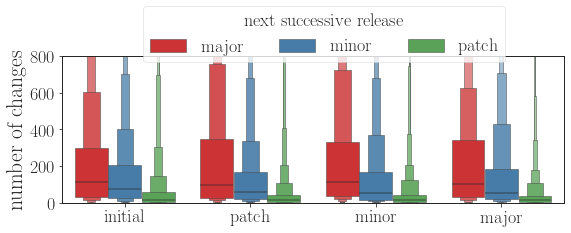

In [210]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="previous", 
                 y='changes',
                 hue='release',
                 order = ['initial','patch','minor','major'],
                 hue_order = ['major','minor','patch'],
                 data=lines, 
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='number of changes',
    ylim=(0,800)
)
ax.legend( title ='next successive release', ncol=4, bbox_to_anchor= (0.9, 1.4))
plt.yticks(pd.np.arange(0, 801, 200)) 


# RQ2: Continue with time

In [ ]:
releases_date = releases[['id','v1','v2','date','release']]

releases_date['previous'] = releases_date.sort_values(['id','date']).groupby('id').release.shift(1)
releases_date['date'] = releases_date['date'].apply(lambda x: str(x).split()[0])
releases_date['previous_date'] = releases_date.sort_values(['id','date']).groupby('id').date.shift(1)

releases_date.dropna(inplace=True)

In [212]:
releases_date['date'] = pd.to_datetime(releases_date['date'])
releases_date['previous_date'] = pd.to_datetime(releases_date['previous_date'])
releases_date['time'] = (releases_date['date'] - releases_date['previous_date']).dt.days
releases_date.head()

,id,v1,v2,date,release,previous,previous_date,time
0,030.ansible_bfg,1.0.0,1.0.1,2020-04-22,patch,initial,2020-04-21,1
4,030.ansible_firefox,1.0.0,1.0.1,2017-12-26,patch,initial,2017-12-25,1
5,030.ansible_firefox,1.0.1,1.1.0,2018-02-28,minor,patch,2017-12-26,64
6,030.ansible_firefox,1.1.0,1.1.1,2018-03-15,patch,minor,2018-02-28,15
7,030.ansible_firefox,1.1.1,2.0.0,2018-06-10,major,patch,2018-03-15,87


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


([<matplotlib.axis.YTick at 0x7efdea1c2da0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

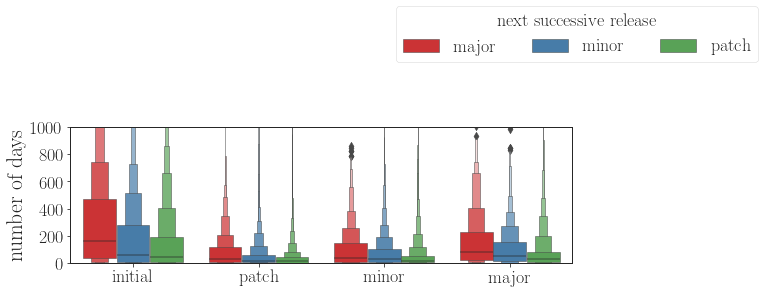

In [213]:
# Number of days to release a new version
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.5)
ax = sns.boxenplot(x="previous", 
                 y="time",
                 hue='release',
                 order = ['initial','patch','minor','major'],
                 hue_order = ['major','minor','patch'],
                 data=releases_date, 
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='number of days',
    ylim=(0,1001)
)
ax.legend( title ='next successive release', ncol=4, bbox_to_anchor= (0.63, 1.41))
plt.yticks(pd.np.arange(0, 1001, 200)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


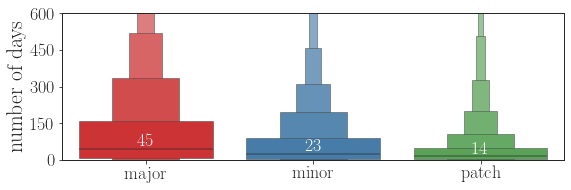

In [221]:
# Number of days between two successive releases
# You can try with ['insertions','deletions','changes']

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="time",
                 data=releases_date, 
                 order = ['major','minor','patch'],
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='number of days',
    ylim=(0,601)
)

position =0
for release in ['major','minor','patch']:
    value = releases_date.query('release == "{}"'.format(release)).time.median()
    ax.annotate('{}'.format(int(value)), (position, value+30), ha='center', va='center', color='white')
    position = position+1
    
plt.yticks(pd.np.arange(0, 601, 150)) 

In [215]:
for r in ['major','minor','patch','initial']:
    print(r, 'mean', releases_date.query('release =="{}"'.format(r))['time'].mean())
    print(r, 'median', releases_date.query('release =="{}"'.format(r))['time'].median())

major mean 136.3995896383688
major median 45.0
minor mean 82.780660766313
minor median 23.0
patch mean 53.30587248615309
patch median 14.0
initial mean 96.93023255813954
initial median 0.0


In [159]:
for r1 in ['major','minor','patch']:
    for r2 in ['major','minor','patch']:
        if r1<=r2:
            continue
        print((r1,r2),scipy.stats.mannwhitneyu(releases_date.query('release =="{}"'.format(r1))['time'],
                                       releases_date.query('release =="{}"'.format(r2))['time']))
        print(effect_size.cliffsDelta(releases_date.query('release =="{}"'.format(r1))['time'],
                                       releases_date.query('release =="{}"'.format(r2))['time']))

                               

('minor', 'major') MannwhitneyuResult(statistic=29856522.5, pvalue=1.1749724518725921e-54)
d=-0.15810213328803963
True
('patch', 'major') MannwhitneyuResult(statistic=78418388.5, pvalue=1.4687375407818778e-213)
d=-0.2973575972096441
True
('patch', 'minor') MannwhitneyuResult(statistic=442914631.5, pvalue=7.630205177874402e-204)
d=-0.14938481735742454
True


# Let's focus on changed files

In [54]:
# Let's distinguish between files and folders
files['directory'] = files.file.apply(lambda x: x.split('/')[0])
files['element'] = files.file.apply(lambda x: x.split('/')[-1])

In [55]:
# How many releases changed wich file
result_tmp = pd.DataFrame()
folders = ['tasks','defaults','meta','templates','vars','files','molecule','tests','handlers']
for r in ['all','patch','minor','major','initial']:
    if r =="all":
        mask  = files.directory.isin(folders)
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release != "initial"')
        tmp_files.drop_duplicates(inplace=True)
        size = len(files
                   .query('release != "initial"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())

        s = len(tmp_files
                   [['id','v1','v2','release']]
                   .drop_duplicates())
        print('proportion of {} releases analyzed {}'.format(r, s*100/size))
        tmp_files = tmp_files.groupby(['directory']).count()[['v1']].reset_index()
        tmp_files['v1'] = tmp_files['v1'].apply(lambda x: round(x*100./size,1))
        tmp_files.rename(columns={'v1':'all'}, inplace=True)
        result_tmp = tmp_files.copy()
    else:
        mask  = files.directory.isin(folders)
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release == "'+r+'"')
        tmp_files.drop_duplicates(inplace=True)
        size = len(files
                   .query('release == "'+r+'"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())

        s = len(tmp_files
                   [['id','v1','v2','release']]
                   .drop_duplicates())
        print('proportion of {} releases analyzed {}'.format(r, s*100/size))
        tmp_files = tmp_files.groupby(['directory','release']).count()[['v1']].reset_index()
        
        tmp_files['v1'] = tmp_files['v1'].apply(lambda x: round(x*100./size,1))
        tmp_files = pd.pivot_table(tmp_files, values='v1', index='directory',
                        columns=['release']).reset_index()
        result_tmp = result_tmp.merge(tmp_files, on =['directory'], how='left')
result_tmp = result_tmp[['directory','patch','minor','major','all','initial']]
print(result_tmp.drop('initial',axis=1).set_index('directory').to_latex())


proportion of all releases analyzed 88.221720467459
proportion of patch releases analyzed 85.04669682324005
proportion of minor releases analyzed 96.19001297016861
proportion of major releases analyzed 97.60161575359757
proportion of initial releases analyzed 99.53338119167265
\begin{tabular}{lrrrr}
\toprule
{} &  patch &  minor &  major &   all \\
directory &        &        &        &       \\
\midrule
defaults  &   29.0 &   56.2 &   67.5 &  37.1 \\
files     &    2.0 &    4.6 &    7.5 &   2.9 \\
handlers  &    4.6 &   11.9 &   17.7 &   6.9 \\
meta      &   22.9 &   33.7 &   54.1 &  26.9 \\
molecule  &   13.1 &   16.6 &   19.7 &  14.3 \\
tasks     &   47.9 &   72.4 &   78.9 &  55.0 \\
templates &   15.9 &   32.7 &   37.9 &  20.8 \\
tests     &    9.7 &   23.4 &   31.0 &  13.9 \\
vars      &   12.8 &   23.7 &   28.6 &  16.1 \\
\bottomrule
\end{tabular}



In [56]:
result_tmp[['directory','initial']]

,directory,initial
0,defaults,88.2
1,files,17.3
2,handlers,60.9
3,meta,98.9
4,molecule,19.2
5,tasks,98.3
6,templates,54.7
7,tests,49.4
8,vars,54.4


In [57]:
folders = ['tasks','defaults','meta','templates','vars']
mask  = files.directory.isin(folders)
tmp_files = files[['id','v1','v2','directory','release']][mask].query('release != "initial"')
tmp_files.drop_duplicates(inplace=True)
size = len(files
           .query('release != "initial"')
           [['id','v1','v2','release']]
           .drop_duplicates())

s = len(tmp_files
           [['id','v1','v2','release']]
           .drop_duplicates())
print('proportion of releases analyzed {}'.format(s*100/size))

tmp_files = tmp_files.groupby(['directory','release']).count()[['v1']].reset_index()
tmp_files['v1'] = tmp_files['v1'].apply(lambda x: round(x*100./size,1))
tmp_files = pd.pivot_table(tmp_files, values='v1', index='directory',
                    columns=['release']).reset_index()
tmp_files['total'] = (tmp_files['major']+tmp_files['minor']+tmp_files['patch'])
print(tmp_files.set_index('directory').to_latex())

proportion of releases analyzed 82.37600178646751
\begin{tabular}{lrrrr}
\toprule
release &  major &  minor &  patch &  total \\
directory &        &        &        &        \\
\midrule
defaults  &    3.3 &   12.9 &   20.9 &   37.1 \\
meta      &    2.7 &    7.7 &   16.5 &   26.9 \\
tasks     &    3.9 &   16.6 &   34.5 &   55.0 \\
templates &    1.9 &    7.5 &   11.4 &   20.8 \\
vars      &    1.4 &    5.4 &    9.2 &   16.0 \\
\bottomrule
\end{tabular}



In [58]:
# Preparation for the venn diagram 
def prepare_venn(files, r=None):
    folders = ['tasks','defaults','meta','templates','vars']
    number={}
    number['tasks']=10000
    number['defaults']=1000
    number['meta']=100
    number['templates']=10
    number['vars']=1

    mask  = files.directory.isin(folders)
    if r:
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release == "'+r+'"')
    else:
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release != "initial"')

    tmp_files['number'] = tmp_files['directory'].apply(lambda x: number[x])
    tmp_files.drop_duplicates(inplace=True)    

    tmp_files = pd.pivot_table(tmp_files, values='number', index=['id', 'v1','v2','release'],
                        columns=['directory']).reset_index().fillna(0)

    tmp_files['number'] = (tmp_files['defaults']+tmp_files['meta']+tmp_files['tasks']
                           +tmp_files['templates']+tmp_files['vars']).apply(int).apply(lambda x: str("%05d"%(x,)))

    tmp_files = tmp_files.groupby('number').count()[['release']].reset_index()

    if r:
        size = len(files
                   .query('release == "'+r+'"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())
    else:
        size = len(files
                   .query('release != "initial"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())
        
    tmp_files['release'] = tmp_files['release'].apply(lambda x: round(x*100./size,1))
    print('proportion of releases analyzed {}'.format(tmp_files.release.sum()))
    
    venn_results = dict(zip(tmp_files.number.tolist(), tmp_files.release.tolist()))
    return venn_results

No handles with labels found to put in legend.


proportion of releases analyzed 82.30000000000001


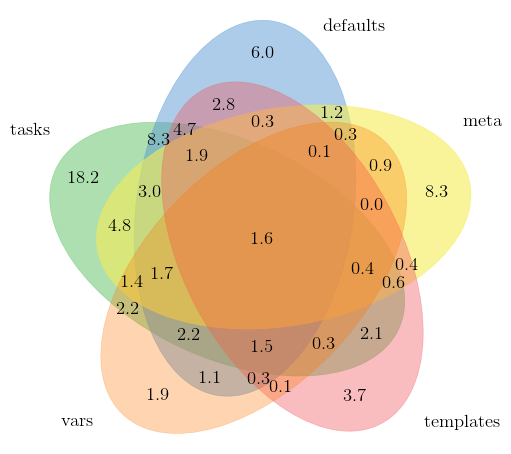

No handles with labels found to put in legend.


proportion of releases analyzed 78.00000000000001


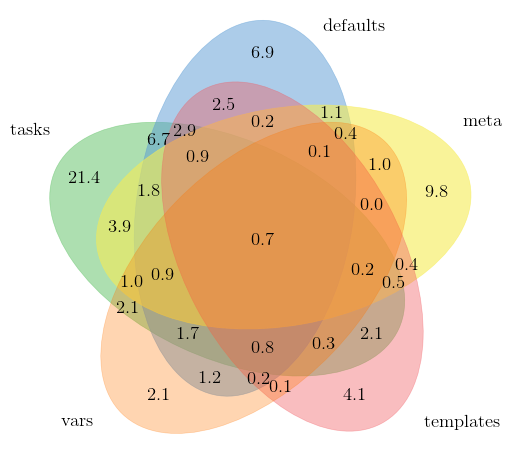

No handles with labels found to put in legend.


proportion of releases analyzed 93.2


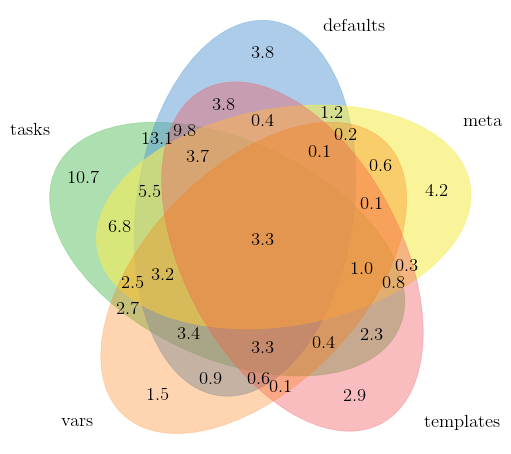

No handles with labels found to put in legend.


proportion of releases analyzed 96.80000000000001


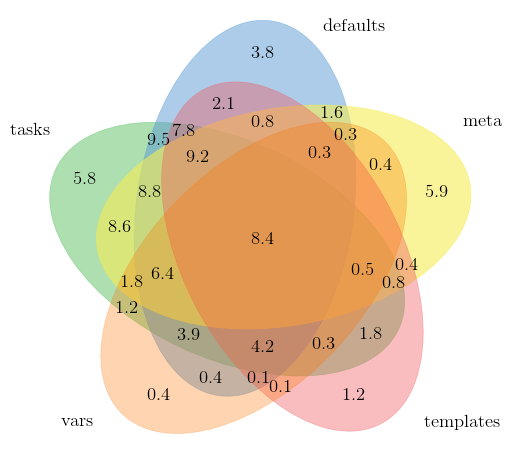

In [59]:
%matplotlib inline
#https://github.com/tctianchi/pyvenn
import ven as venn
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
for index, r in enumerate(['all','patch','minor','major']):
    if r == 'all':
        venn_results = prepare_venn(files)
    else:
        venn_results = prepare_venn(files, r)
    fig, ax = venn.venn5(venn_results, names=folders)
    ax.legend().remove()
    #ax.set_title(r.upper())
    fig.set_size_inches(6,6)
    plt.show(fig)

In [195]:
# Propotion of versions that touched folders
df_tmp=(files
        .query('directory != element') # consider only files
        .query('release != "initial"') # Remove the first release
        [['id','v1','v2','directory','release']]
        .drop_duplicates()
        .groupby('directory')
        .count()
        .sort_values('release', ascending=False)
        [['release']]
        .reset_index()
)

size = len(files
     .query('release != "initial"') # Remove the first release
     [['id','v1','v2','release']]
     .drop_duplicates())

df_tmp['versions'] = df_tmp.release*100./size
list_files = df_tmp.head(8).directory

In [196]:
df_tmp.head(10)

,directory,release,versions
0,tasks,44338,54.994915
1,defaults,29944,37.141227
2,meta,21679,26.889683
3,templates,16789,20.824341
4,vars,12958,16.072536
5,molecule,11493,14.255414
6,tests,11218,13.914316
7,handlers,5586,6.928630
8,.github,3687,4.573193
9,files,2307,2.861502


In [197]:
len(files.query('release != "initial"')[['id','v1','v2']].drop_duplicates()), size

(80622, 80622)

(0.0, 100.0)

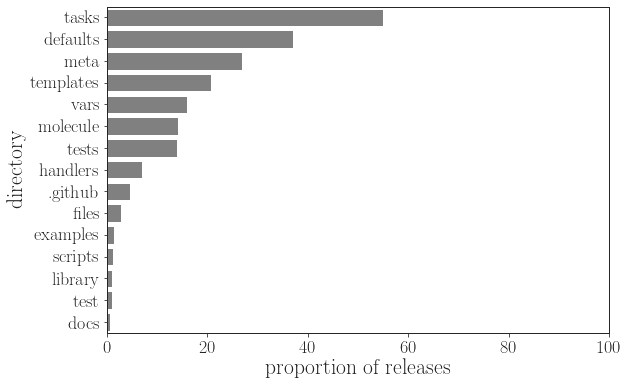

In [200]:
ax = sns.barplot(x="versions", 
                 y="directory", 
                 data=df_tmp.head(15), 
                 color='gray',
                 linewidth=1)
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)


In [205]:
df_tmp=(files
        .query('directory != element')
        .query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"')
        [['id','v1','v2','directory','release']]
 .drop_duplicates()
 .groupby(['release','directory'])
 .count()
 .sort_values('id', ascending=False)
 [['id']]
 .reset_index()
)

df_tmp =  df_tmp[df_tmp.directory.isin(list_files)]


df_tmp2=(files
        [['id','v1','v2','release']]
 .drop_duplicates()
 .groupby('release')
 .count()
 [['v1']]
 .reset_index()
)

df_tmp = (df_tmp
          .merge(df_tmp2,
                 on = ['release'])
         )
df_tmp ['versions'] = df_tmp ['id']*100./df_tmp ['v1']
df_tmp.sample()

,release,directory,id,v1,versions
12,minor,vars,4388,18504,23.713792


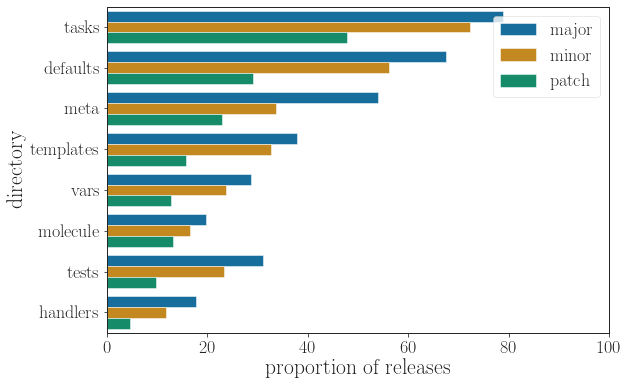

In [206]:
ax = sns.barplot(y="directory", 
                 x="versions", 
                 hue = 'release',
                 data=df_tmp, 
                 order=list_files,
                 hue_order = ['major','minor','patch'],
                 #color='blue'
                )
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)
ax.legend(loc='upper right') #handles=legend_elements, 

# Comment: Use stacked barplots

In [ ]:
df_tmp= files[files.directory.isin(list_files)]

df_tmp['changes'] = df_tmp['insertions'] + df_tmp['deletions']
df_tmp = df_tmp[['directory','release','changes','deletions','insertions']]

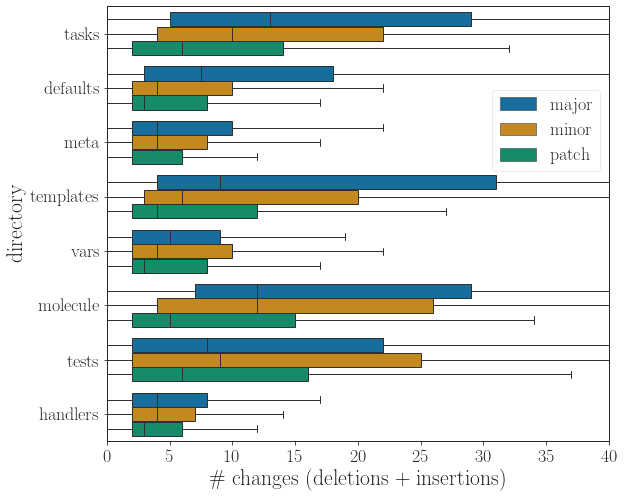

In [236]:
ax = sns.boxplot(x="changes", 
                 y="directory", 
                 hue='release',
                 order = list_files,
                 hue_order = ['major','minor','patch'],
                 data=df_tmp,                  
                 showfliers=False,
                 linewidth=1)
ax.figure.set_size_inches(9,8)
ax.set_xlabel("\# changes (deletions + insertions)")
ax.set_xlim(0,40)
ax.legend(bbox_to_anchor= (0.75, 0.6), ncol=1)

(0.0, 40.0)

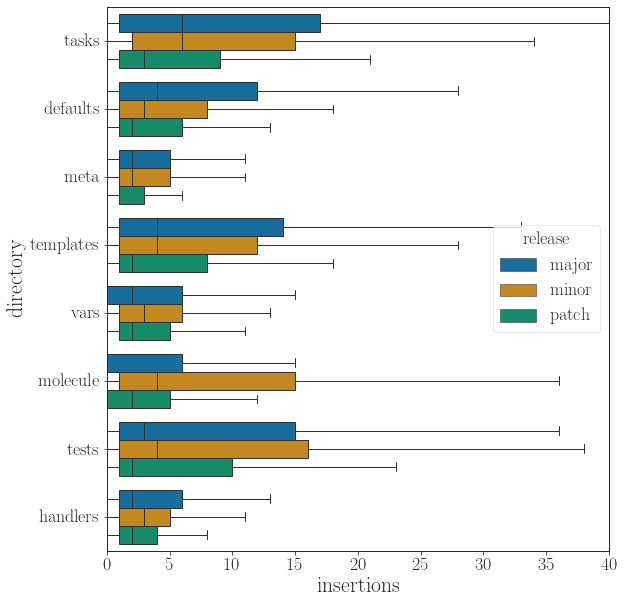

In [212]:
ax = sns.boxplot(x="insertions", 
                 y="directory", 
                 hue='release',
                 order = list_files,
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 #color='blue',
                 showfliers=False,
                 linewidth=1)
ax.figure.set_size_inches(9,10)
ax.set_xlim(0,40)

(0.0, 60.0)

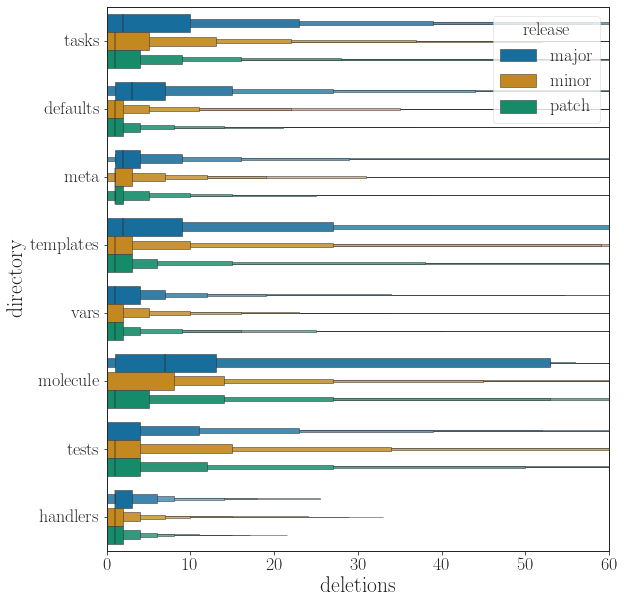

In [210]:
ax = sns.boxenplot(x="deletions", 
                 y="directory", 
                 hue='release',
                 order = list_files,
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 #color='blue',
                 showfliers=False,
                 linewidth=1)
ax.figure.set_size_inches(9,10)
#ax.set_xlabel("")
#ax.set_xlabel('proportion of releases')
ax.set_xlim(0,60)

(0.0, 100.0)

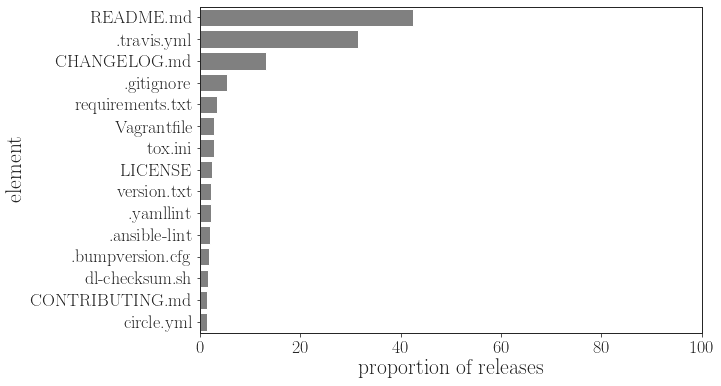

In [75]:
# Now let's check the files that are in the root
df_tmp=(files
        .query('directory == element')
        .query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"')
        [['id','v1','v2','element','release']]
 .drop_duplicates()
 .groupby('element')
 .count()
 .sort_values('release', ascending=False)
 [['release']]
 .reset_index()
)
df_tmp['versions'] = df_tmp.release*100./len(files[['id','v1','v2','release']].query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"').drop_duplicates())
list_elements = df_tmp.head(9).element

ax = sns.barplot(x="versions", 
                 y="element", 
                 data=df_tmp.head(15), 
                 color='gray',
                 linewidth=1)
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)

(0.0, 100.0)

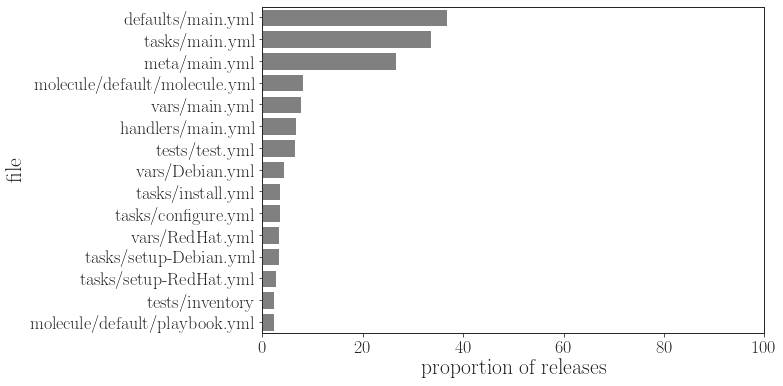

In [76]:
# Now let's check all files
df_tmp=(files
        .query('directory != element')
        .query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"')
        [['repo','v1','v2','file','release']]
 .drop_duplicates()
 .groupby('file')
 .count()
 .sort_values('release', ascending=False)
 [['release']]
 .reset_index()
)
df_tmp['versions'] = df_tmp.release*100./len(files[['repo','v1','v2','release']].query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"').drop_duplicates())
list_elements = df_tmp.head(15).file

ax = sns.barplot(x="versions", 
                 y="file", 
                 data=df_tmp.head(15), 
                 color='gray',
                 linewidth=1)
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)

# Let's check version 0.x.y

In [380]:
releases['zero'] = releases['v2'].apply(lambda x: x.startswith('0.'))

In [381]:
releases['date_previous'] = releases.sort_values(['id','date']).groupby('id').date.shift(1)

In [382]:
releases_zero = releases.query('release != "initial"').sort_values('date_previous').dropna()

In [383]:
releases_zero['days'] = (releases_zero['date'] - releases_zero['date_previous']).dt.days

In [384]:
mask = releases_zero.id.isin(releases_zero.query('zero == True').id)
releases_zero = releases_zero[mask]

In [385]:
releases_zero.id.unique().size

2489

In [386]:
releases_zero.query('zero==False').id.unique().size

497

[Text(0.5, 0, ''), Text(0, 0.5, 'days'), (0.0, 900.0)]

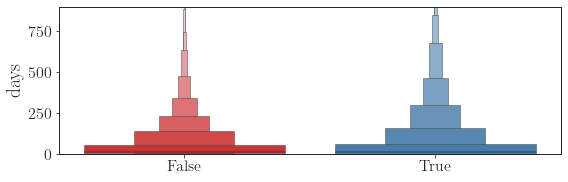

In [388]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="zero", 
                 y="days",
                 data=releases_zero, 
                 #order = ['major','minor','patch','initial'],
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='days',
    ylim=(0,900)
)

In [389]:
print('Mannwhitney U test')
scipy.stats.mannwhitneyu(releases_zero.query('zero == True').days,
                         releases_zero.query('zero == False').days)
print("Cliff's Delta")
effect_size.cliffsDelta(releases_zero.query('zero == True').days,
                         releases_zero.query('zero == False').days)

Mannwhitney U test
Cliff's Delta
d=-0.08790836100880035


False

#### Apparently there is no big difference between 0.x.y versions and the other versions

# Let's check the number of version per category

We check whether some categories release more often

In [281]:
tags = pd.read_csv('../data/tags_and_roles.csv.gz')
tags.head(2)

,tag,role_id
0,database,bennojoy.mysql
1,sql,bennojoy.mysql


In [284]:
tags.role_id.unique().size, releases.id.unique().size

(22917, 11158)

In [283]:
releases.head(2)

,id,v1,v2,date,fromm,tot,release
0,030.ansible_bfg,1.0.0,1.0.1,2020-04-22 10:25:51,1.0.0,1.0.1,patch
1,030.ansible_bfg,4b825dc642cb6eb9a060e54bf8d69288fbee4904,1.0.0,2020-04-21 21:52:18,first commit,1.0.0,initial


In [358]:
num_releases = (releases[['id','v1','v2','release']]
                .drop_duplicates()
                .rename(columns={'id':'role_id'})
                .groupby('role_id')
                .count()[['release']]
                .reset_index()
                .merge(tags,
                       on = ['role_id']
                      )
               )
for x in num_releases.groupby('tag').count()[['role_id']].sort_values('role_id', ascending=False).head(30).index.tolist():
    print(x, num_releases.query('tag =="{}"'.format(x)).release.median())

system 4.0
development 5.0
web 6.0
monitoring 4.5
networking 5.0
database 5.0
cloud 4.0
packaging 5.0
docker 4.0
ubuntu 3.0
security 3.0
server 5.0
centos 4.0
debian 3.0
php 6.0
java 6.0
nginx 5.0
sql 8.0
python 4.0
ssh 3.0
mysql 4.0
prometheus 3.0
linux 2.0
aws 2.0
kubernetes 3.0
logging 5.0
postgresql 4.5
clustering 4.0
nosql 5.0
ssl 4.0


In [359]:
num_releases2 = (releases[['id','v1','v2','release']]
                .drop_duplicates()
                .rename(columns={'id':'role_id'})
                .groupby(['role_id','release'])
                .count()[['v1']]
                .reset_index()
                .merge(tags,
                       on = ['role_id']
                      )
               )
for x in num_releases.groupby('tag').count()[['role_id']].sort_values('role_id', ascending=False).head(10).index.tolist():
    print('____________',x,'____________')
    for y in ['patch','minor','major']:
        print(y, num_releases2.query('tag =="{}" and release =="{}"'.format(x,y)).v1.median())

____________ system ____________
patch 4.0
minor 2.0
major 1.0
____________ development ____________
patch 5.0
minor 3.0
major 1.0
____________ web ____________
patch 6.0
minor 3.0
major 1.0
____________ monitoring ____________
patch 4.0
minor 2.0
major 1.0
____________ networking ____________
patch 5.0
minor 2.0
major 1.0
____________ database ____________
patch 5.0
minor 3.0
major 1.0
____________ cloud ____________
patch 3.0
minor 2.0
major 1.0
____________ packaging ____________
patch 4.0
minor 3.0
major 1.0
____________ docker ____________
patch 4.0
minor 2.0
major 1.0
____________ ubuntu ____________
patch 3.0
minor 3.0
major 1.0


In [338]:
num_releases.release.sum()

10287

In [367]:
tmp = num_releases.drop('tag', axis=1).drop_duplicates()
print(tmp.release.sum())
a = tmp.release.quantile(0.8) 
tmp.query('release > {}'.format(a)).release.sum()/tmp.release.sum()


88442


0.6599805522263178

In [365]:
print(num_releases2.drop('tag',axis=1).drop_duplicates().v1.sum())

for r in ['patch','minor','major']:
    tmp = num_releases2.drop('tag',axis=1).query('release == "{}"'.format(r)).drop_duplicates()
    print(r, tmp.query('v1 > {}'.format(tmp.v1.quantile(0.8) )).v1.sum()/tmp.v1.sum())


88442
patch 0.6572947388870247
minor 0.5575945793337098
major 0.2990580847723705


In [325]:
a = num_releases2.query('release == "major"').v1.quantile(0.8) 
num_releases2.query('release == "major"').query('v1 > {}'.format(a)).v1.sum()/num_releases2.query('release == "major"').v1.sum()

0.3439807031649733

In [327]:
a = num_releases2.query('release == "patch"').v1.quantile(0.8) 
num_releases2.query('release == "patch"').query('v1 > {}'.format(a)).v1.sum()/num_releases2.query('release == "patch"').v1.sum()


0.6456458709597895

In [328]:
a = num_releases2.query('release == "minor"').v1.quantile(0.8) 
num_releases2.query('release == "minor"').query('v1 > {}'.format(a)).v1.sum()/num_releases2.query('release == "minor"').v1.sum()


0.558703463037994

In [329]:
a = num_releases2.query('release == "initial"').v1.quantile(0.8) 
num_releases2.query('release == "initial"').query('v1 > {}'.format(a)).v1.sum()/num_releases2.query('release == "initial"').v1.sum()


0.0